### 2023.07.07 : TSA_01_(Adfuller_TEST)
- data를 Load 하고 기본적인 transform을 진행하여 모델에 입력 가능하도록 정비한다.

### 2023.07.07 : TSA_01
- Adfuller stationary (Dickey Fuller) Test 확인
- 전체 데이터를 하나의 frame으로 묶어야 하는가?
- transform을 하기 위한 정보 dict 를 만들어야 하는가?

### 2023.07.10 : TSA_02
- lag를 반영하는 정상성 확보 변환 계열을 로드한다.
- 로드한 데이터를 em-DFM 모델에 입력하고 소스자료에 따라 분석을 진행한다.

### 2023.07.11 : TSA_02_02
- lag를 반영하는 정상성 확보 변환 계열을 로드한다.
  > - data loader 에서 반영 필요
  > - outlier에 대한 반영도 추가
- factor order 에 대한 설정 확인.
- 로드한 데이터를 em-DFM 모델에 입력하고 소스자료에 따라 분석을 진행한다.



In [ ]:
# colab 한글 font 사용을 위한 font 설치
# install 후 restart session
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# os.chdir(r'D:\2023\Sadj\x13as_ascii-v1-1-b59\x13as')
from datetime import datetime as dt
import time

import types
import numpy as np
import pandas as pd
import openpyxl
import pprint as pp

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print("Python set up modules loaded")
print("Python version:\n", os.sys.version, "\nPlatform: ", os.sys.platform)
print("Base directory path:", os.getcwd())
print("Data/time:", dt.now())

import statsmodels as sma
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# from statsmodels.tsa.x13 import x13_arima_select_order, _find_x12 # local에서 x13_arima_seats를 이용하여 계절조정 필요한 계열에 적용하였음.

print("STATSMODELS info (statsmodels._version.version)", sma._version.version)
# v0.13.0 만 json version 정보 있음. v0.14.0 부터 없음.

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
%matplotlib inline
import seaborn as sns


Python set up modules loaded
Python version:
 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0] 
Platform:  linux
Base directory path: /content
Data/time: 2023-07-12 11:23:51.919388
STATSMODELS info (statsmodels._version.version) 0.13.5


In [ ]:
# functions

def remove_outliers(dta):
    # Compute the mean and interquartile range
    mean = dta.mean()
    iqr = dta.quantile([0.25, 0.75]).diff().T.iloc[1]
    # Replace entries that are more than 10 times the IQR
    # away from the mean with NaN (denotes a missing entry)
    mask = np.abs(dta) > mean + 10 * iqr
    treated = dta.copy()
    treated[mask] = np.nan
    return treated

def adf_test(transformed):
    if (result := adfuller(transformed.values))[1] < 0.05:
        test_result = "{}".format("S")
    else:
        test_result = "{}".format("N")
    return test_result

def transform(df, var_info, start, end, freq):
    for col in df.columns:
        # print(f"transform_column : {col}")
        diff = var_info[var_info['ID'] == col]['transform'].values[0]
        lag = var_info[var_info['ID'] == col]['LAG'].values[0]
        df_trans = df.copy()
        # transform N test
        if diff == 'Origin':
            treated = remove_outliers(df[col][start:end])
            transformed = treated.dropna()
            res = adf_test(transformed)
        elif diff == 'Diff-1':
            treated = remove_outliers(df[col][start:end])
            transformed = treated.diff().dropna()
            res = adf_test(transformed)
            df_trans[col] = transformed
        elif diff == 'Log-1':
            # error transform log list
            if col in ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']:
                res = 'X'
            else:
                treated = remove_outliers(df[col][start:end])
                transformed = np.log(treated).dropna()
                res = adf_test(transformed)
            df_trans[col] = transformed
        elif diff == 'Diff-2':
            treated = remove_outliers(df[col][start:end])
            transformed = treated.diff().diff().dropna()
            res = adf_test(transformed)
            df_trans[col] = transformed
        else:
            print(f"transformation not orderred")
        # if res == 'N' or res == 'X':
        #     return print(f"transformed data column variable stationary Adfuller Test is fail: variable name ={col},{diff},{res}")

    return df_trans

def set_lag_DFM(df_trans, var_info, start, end, freq):
    df_set_lag = df_trans.copy()
    if freq == 'M':
      for col in df_trans.columns:
        # print(f"set_lag_column : {col}")
        lag = var_info[var_info['ID'] == col]['LAG'].values[0]
        df_set = df_trans[col][start:end]
        if lag > 0:
          df_set = df_set[:-(lag)]
        else:
          df_set = df_set
        # print(f"df_set {col} : {df_set}")
        df_set_lag[col] = df_set
      df_set_lag = df_set_lag[start:end]
    else:
      df_set = df_trans[start:end]
      df_set_lag = df_set
      df_set_lag = df_set_lag[start:end]
    return df_set_lag


def load_data_DFM(data_path, start, end):
    # load data
    # Quatery
    df_Q = pd.read_excel(data_path, index_col='date', sheet_name='df_Q', header=0)
    p_rng_q = pd.period_range('1960Q2', '2023Q1', freq='Q-FEB')
    df_Q = df_Q.set_index(p_rng_q)
    df_Q = df_Q.iloc[:,:].astype('float')
    df_Q.index.name = 'date'
    # df_Q = remove_outliers(df_Q)
    # Monthly
    df_M = pd.read_excel(data_path, index_col='date', sheet_name='df_M', header=0)
    p_rng_m = pd.period_range('1970-01-01', '2023-06-01', freq='m')
    df_M = df_M.set_index(p_rng_m)
    df_M = df_M.iloc[:,:].astype('float')
    df_M.index.name = 'date'
    # df_M = remove_outliers(df_M)
    # Variable Info
    var_info = pd.read_excel(data_path, sheet_name='df_var_info', header=0)
    # diff transform for stationary
    df_Q_trans = transform(df_Q, var_info, start, end, 'Q')
    df_M_trans = transform(df_M, var_info, start, end, 'M')
    return df_Q, df_Q_trans, df_M, df_M_trans, var_info


# Nueral Network  Model dataloader
def load_data_NN(data_path):
    # load data
    df_Q = pd.read_excel(data_path, sheet_name='df_Q', header=0)
    df_M = pd.read_excel(data_path, sheet_name='df_M', header=0)
    var_info = pd.read_excel(data_path, sheet_name='df_var_info', header=0)
    return df_Q, df_M, var_info


In [ ]:
# data for function test
path = '/content/drive/MyDrive/ZZ/Code_02/Base_data'
file = 'dataset_03_S.xlsx'
data_path = os.path.join(path, file)
start = '2000-01'
end = '2022-12'

df_Q, df_Q_trans, df_M, df_M_trans, var_info = load_data_DFM(data_path,start,end)

df_Q_trans_set = set_lag_DFM(df_Q_trans, var_info, start, end, 'Q')
df_M_trans_set = set_lag_DFM(df_M_trans, var_info, start, end, 'M')

# df_Q, df_M, var_info = load_data_NN(data_path)

In [ ]:
var_info.columns

Index(['Unnamed: 0', 'ID', 'Group', 'factors', 'Variable', 'description', '단위',
       'FEQ', 'LAG', '계절조정', 'X13-arima', 'transform', '비고'],
      dtype='object')

description: 20    Credit card usage amount
Name: description, dtype: object


<Axes: xlabel='date'>

[Text(0.5, 1.0, 'Original data'), (360.0, 624.0), Text(0, 0.5, '백만원')]

<Axes: xlabel='date'>

iqr : 22600538.54423765


[Text(0.5, 1.0, 'Transformed data, with bands showing outliers cutoffs'),
 (360.0, 624.0),
 (-176753015.45768112, 275257755.42707187),
 Text(0, 0.5, '백만원')]

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


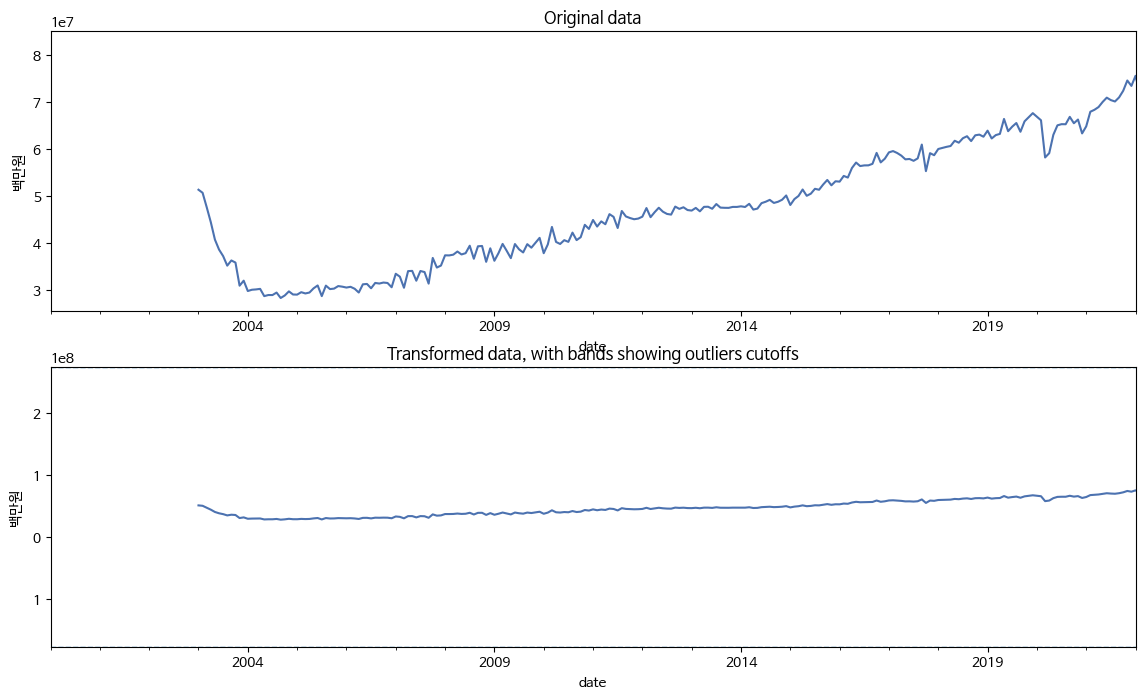

In [ ]:
with sns.color_palette('deep'):
    fig, axes = plt.subplots(2, figsize=(14, 8))

    # Plot the raw data from the February 2020 vintage, for:
    #
    vintage = '2022-12'
    variable = 'I21'
    description = var_info[var_info['ID'] == variable]['description']#.values[0]
    print(f"description: {description}")
    start = '2000-01'
    end = '2022-12'

    # 1. Plot the original dataset, for 2000-01 through 2020-01
    df_M.loc[start:end, variable].plot(ax=axes[0])
    axes[0].set(title='Original data', xlim=('2000','2022'), ylabel='백만원')

    # 2. Plot the transformed data, still including outliers
    # (we only stored the transformation with outliers removed, so
    # here we'll manually perform the transformation)
    transformed = transform(df_M,var_info, start, end, 'M')
    transformed[variable].loc[start:end].plot(ax=axes[1])
    mean = transformed[variable].mean()
    iqr = transformed[variable].quantile([0.25, 0.75]).diff().iloc[1]
    print(f"iqr : {iqr}")
    axes[1].hlines([mean - 10 * iqr, mean + 10 * iqr],
                   transformed.index[0], transformed.index[-1],
                   linestyles='--', linewidth=1)
    axes[1].set(title='Transformed data, with bands showing outliers cutoffs',
                xlim=('2000','2022'), ylim=(mean - 10 * iqr, mean + 10 * iqr),
                ylabel='백만원')
    # axes[1].annotate('Outlier', xy=('2013-01', transformed.loc['2013-01']),
    #                  xytext=('2014-01', -5.3), textcoords='data',
    #                  arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),)

    # # 3. Plot the transformed data, with outliers removed (see missing value for 2013-01)
    # dta[vintage].dta_m.loc[start:end, 'RPI'].plot(ax=axes[2])
    # axes[2].set(title='Transformed data, with outliers removed',
    #             xlim=('2000','2020'), ylabel='Percent')
    # axes[2].annotate('Missing value in place of outlier', xy=('2013-01', -1),
    #                  xytext=('2014-01', -2), textcoords='data',
    #                  arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

    # fig.suptitle('Real Personal Income (RPI)',
    #              fontsize=12, fontweight=600)

    # fig.tight_layout(rect=[0, 0.00, 1, 0.95]);

In [ ]:
df_Q_trans_set.tail(10)

,A1,A2,A3,A4,A5,A6
date,,,,,,
2018Q3,0.6,0.7,-3.4,-3.9,4.1,-1.8
2018Q4,0.6,0.7,2.8,-0.3,-2.5,1.5
2019Q1,-0.1,0.5,-7.6,-0.8,-4.8,-4.7
2019Q2,1.1,0.1,2.9,3.0,1.8,3.1
2019Q3,0.4,0.9,0.2,-2.4,3.9,0.6
2019Q4,1.2,0.8,2.9,4.1,0.8,0.0
2020Q1,-1.3,-6.3,0.1,1.3,-0.8,-1.4
2020Q2,-3.0,0.6,1.7,-2.2,-13.9,-3.7
2020Q3,2.3,0.7,5.5,-2.3,17.0,6.9


<Figure size 1000x300 with 0 Axes>

<Axes: xlabel='date'>

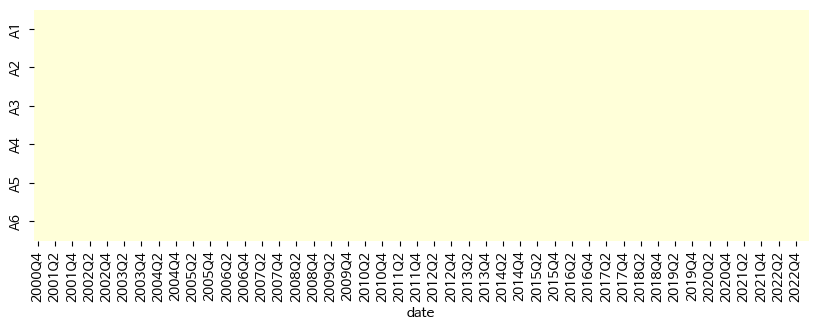

In [ ]:
# check null
plt.figure(figsize=(10,3))
sns.heatmap(df_Q_trans_set.isna().transpose(),
            cmap="YlGnBu",
            cbar=False,
            # cbar_kws={'label': 'Missing Data'}
            )
plt.show()

<Figure size 1000x1800 with 0 Axes>

<Axes: xlabel='date'>

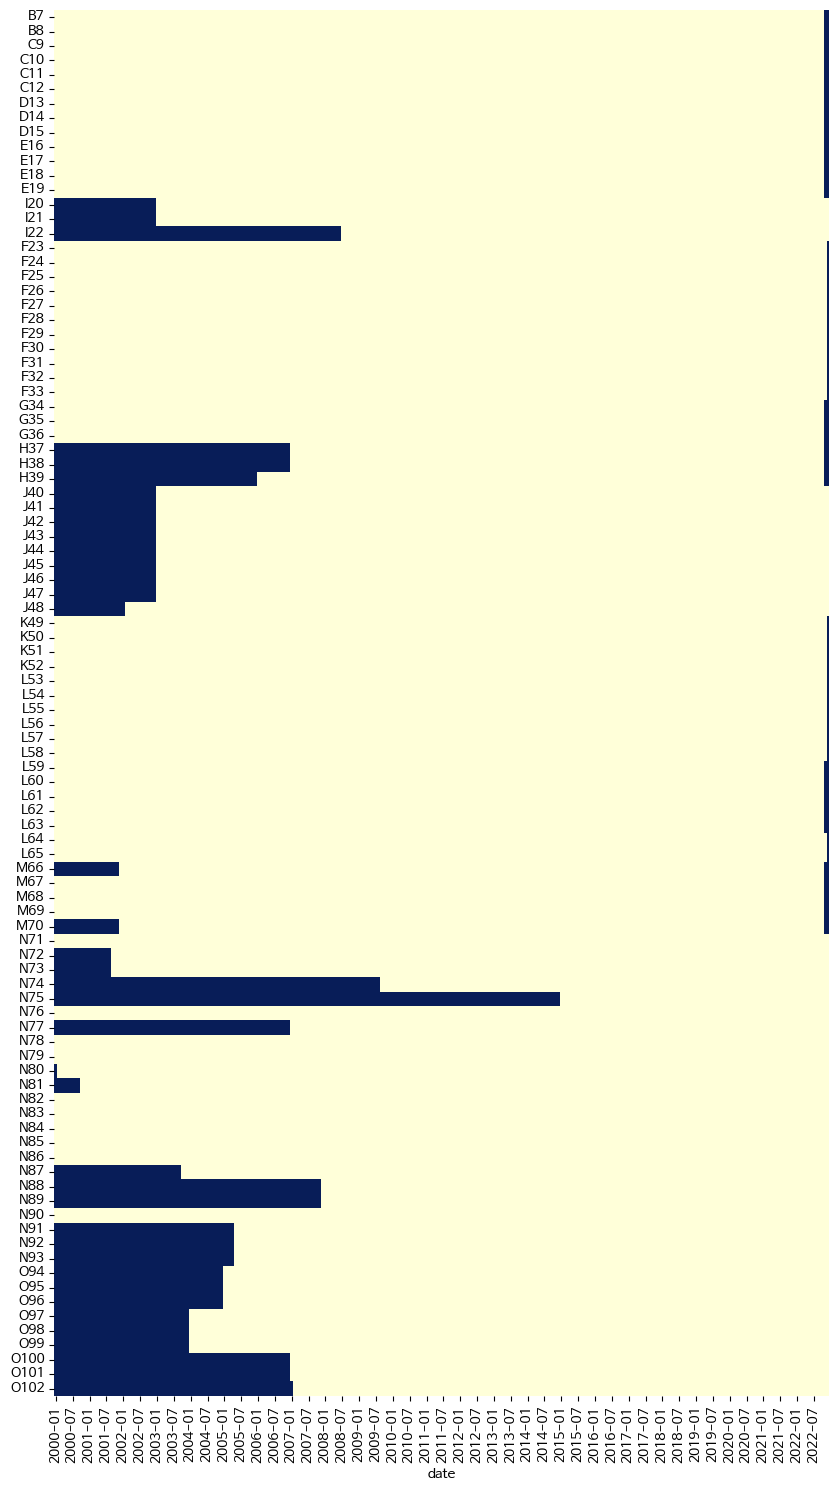

In [ ]:
plt.figure(figsize=(10,18))
sns.heatmap(df_M_trans_set.isna().transpose(),
            cmap="YlGnBu",
            cbar=False,
            # cbar_kws={'label': 'Missing Data'}
            )
plt.show()

In [ ]:
factors = {
        'A1':['Global'],
        'A2':['Global','Customer'],
        'A3':['Global','Company'],
        'A4':['Global','Company'],
        'A5':['Global','Trade'],
        'A6':['Global','Trade'],
        # 'A2':['Global'],
        # 'A3':['Global'],
        # 'A4':['Global'],
        # 'A5':['Global'],
        # 'A6':['Global'],
        'B7':['Global','Economic'],
        'B8':['Global','Economic'],
        'C9':['Global','Company'],
        'C10':['Global','Company'],
        'C11':['Global','Company'],
        'C12':['Global','Company'],
        'D13':['Global','Company','Economic'],
        'D14':['Global','Company','Economic'],
        'D15':['Global','Company','Economic'],
        'E16':['Global','Customer','Economic'],
        'E17':['Global','Customer','Economic'],
        'E18':['Global','Customer','Economic'],
        'E19':['Global','Customer','Economic'],
        'F20':['Global','Company','Economic'],
        'F21':['Global','Company','Economic'],
        'F22':['Global','Company','Economic'],
        'F23':['Global','Customer','Economic'],
        'F24':['Global','Customer','Economic'],
        'F25':['Global','Customer','Economic'],
        'F26':['Global','Customer','Economic'],
        'F27':['Global','Customer','Economic'],
        'F28':['Global','Customer','Economic'],
        'F29':['Global','Customer','Economic'],
        'F30':['Global','Customer','Economic'],
        'G31':['Global','Company','	Economic'],
        'G32':['Global','Company','	Economic'],
        'G33':['Global','Company','	Economic'],
        'H34':['Global','Company','	Economic'],
        'H35':['Global','Company','	Economic'],
        'H36':['Global','Company','	Economic'],
        'I37':['Global','Customer','Economic'],
        'I38':['Global','Customer','Economic'],
        'I39':['Global','Customer','Economic'],
        'J40':['Global','Company','Economic'],
        'J41':['Global','Company','Economic'],
        'J42':['Global','Company','Economic'],
        'J43':['Global','Company','Economic'],
        'J44':['Global','Company','Economic'],
        'J45':['Global','Company','Economic'],
        'J46':['Global','Company','Economic'],
        'J47':['Global','Company','Economic'],
        'J48':['Global','Company','Economic'],
        'K49':['Global','Customer','Economic'],
        'K50':['Global','Customer','Economic'],
        'K51':['Global','Customer','Economic'],
        'K52':['Global','Customer','Economic'],
        'L53':['Global','Trade','Economic'],
        'L54':['Global','Trade','Economic'],
        'L55':['Global','Trade','Economic'],
        'L56':['Global','Trade','Economic'],
        'L57':['Global','Trade','Economic'],
        'L58':['Global','Trade','Economic'],
        'L59':['Global','Trade','Economic'],
        'L60':['Global','Trade','Economic'],
        'L61':['Global','Trade','Economic'],
        'L62':['Global','Trade','Economic'],
        'L63':['Global','Trade','Economic'],
        'L64':['Global','Trade','Economic'],
        'L65':['Global','Company','Trade','Economic'],
        'M66':['Global','Trade','Finance'],
        'M67':['Global','Trade','Finance'],
        'M68':['Global','Trade','Finance'],
        'M69':['Global','Trade','Finance'],
        'M70':['Global','Trade','Finance'],
        'N71':['Global','Trade','Finance'],
        'N72':['Global','Customer','Finance'],
        'N73':['Global','Company','Finance'],
        'N74':['Global','Customer','Finance'],
        'N75':['Global','Customer','Finance'],
        'N76':['Global','Company','Finance'],
        'N77':['Global','Company','Finance'],
        'N78':['Global','Company','Finance'],
        'N79':['Global','Company','Finance'],
        'N80':['Global','Company','Finance'],
        'N81':['Global','Company','Finance'],
        'N82':['Global','Company','Finance'],
        'N83':['Global','Finance'],
        'N84':['Global','Finance'],
        'N85':['Global','Finance'],
        'N86':['Global','Finance'],
        'N87':['Global','Customer','Finance'],
        'N88':['Global','Customer','Finance'],
        'N89':['Global','Customer','Finance'],
        'N90':['Global','Company','Finance'],
        'N91':['Global','Company','Finance'],
        'N92':['Global','Customer','Finance'],
        'N93':['Global','Customer','Finance'],
        'O94':['Global','Finance'],
        'O95':['Global','Finance'],
        'O96':['Global','Finance'],
        'O97':['Global','Finance'],
        'O98':['Global','Finance'],
        'O99':['Global','Finance'],
        'O100':['Global','Finance'],
        'O101':['Global','Finance'],
        'O102':['Global','Finance']
}

In [ ]:

factors = {
        'A1':['Global'],
        'A2':['Global'],
        'A3':['Global'],
        'A4':['Global'],
        'A5':['Global'],
        'A6':['Global'],
        'B7':['Global','Total_economic'],
        'B8':['Global','Total_economic'],
        'C9':['Global','Ind_prd_economic'],
        'C10':['Global','Ind_prd_economic'],
        'C11':['Global','Ind_prd_economic'],
        'C12':['Global','Ind_prd_economic'],
        'D13':['Global','Mnf_economic'],
        'D14':['Global','Mnf_economic'],
        'D15':['Global','Mnf_economic'],
        'E16':['Global','CS_economic'],
        'E17':['Global','CS_economic'],
        'E18':['Global','CS_economic'],
        'E19':['Global','CS_economic'],
        'I20':['Global','CS_economic'],
        'I21':['Global','CS_economic'],
        'I22':['Global','CS_economic'],
        'F23':['Global','Price'],
        'F24':['Global','Price'],
        'F25':['Global','Price'],
        'F26':['Global','Price'],
        'F27':['Global','Price'],
        'F28':['Global','Price'],
        'F29':['Global','Price'],
        'F30':['Global','Price'],
        'F31':['Global','Price'],
        'F32':['Global','Price'],
        'F33':['Global','Price'],
        'G34':['Global','Investment'],
        'G35':['Global','Investment'],
        'G36':['Global','Investment'],
        'H37':['Global','Construct'],
        'H38':['Global','Construct'],
        'H39':['Global','Construct'],
        'J40':['Global','Suveys_BSI'],
        'J41':['Global','Suveys_BSI'],
        'J42':['Global','Suveys_BSI'],
        'J43':['Global','Suveys_BSI'],
        'J44':['Global','Suveys_BSI'],
        'J45':['Global','Suveys_BSI'],
        'J46':['Global','Suveys_BSI'],
        'J47':['Global','Suveys_BSI'],
        'J48':['Global','Suveys_BSI'],
        'K49':['Global','Labor'],
        'K50':['Global','Labor'],
        'K51':['Global','Labor'],
        'K52':['Global','Labor'],
        'L53':['Global','International_trade'],
        'L54':['Global','International_trade'],
        'L55':['Global','International_trade'],
        'L56':['Global','International_trade'],
        'L57':['Global','International_trade'],
        'L58':['Global','International_trade'],
        'L59':['Global','International_trade'],
        'L60':['Global','International_trade'],
        'L61':['Global','International_trade'],
        'L62':['Global','International_trade'],
        'L63':['Global','International_trade'],
        'L64':['Global','International_trade'],
        'L65':['Global','International_trade'],
        'M66':['Global','Currency'],
        'M67':['Global','Currency'],
        'M68':['Global','Currency'],
        'M69':['Global','Currency'],
        'M70':['Global','Currency'],
        'N71':['Global','Bank_rate'],
        'N72':['Global','Bank_rate'],
        'N73':['Global','Bank_rate'],
        'N74':['Global','Bank_rate'],
        'N75':['Global','Bank_rate'],
        'N76':['Global','Bank_rate'],
        'N77':['Global','Bank_rate'],
        'N78':['Global','Bank_rate'],
        'N79':['Global','Bank_rate'],
        'N80':['Global','Bank_rate'],
        'N81':['Global','Bank_rate'],
        'N82':['Global','Bank_rate'],
        'N83':['Global','Bank_rate'],
        'N84':['Global','Bank_rate'],
        'N85':['Global','Bank_rate'],
        'N86':['Global','Bank_rate'],
        'N87':['Global','Bank_rate'],
        'N88':['Global','Bank_rate'],
        'N89':['Global','Bank_rate'],
        'N90':['Global','Bank_rate'],
        'N91':['Global','Bank_rate'],
        'N92':['Global','Bank_rate'],
        'N93':['Global','Bank_rate'],
        'O94':['Global','Finance'],
        'O95':['Global','Finance'],
        'O96':['Global','Finance'],
        'O97':['Global','Finance'],
        'O98':['Global','Finance'],
        'O99':['Global','Finance'],
        'O100':['Global','Finance'],
        'O101':['Global','Finance'],
        'O102':['Global','Finance']
}


In [ ]:
factor_orders = {
    'Global' : 4
}

In [ ]:
factor_orders = {
     'Global' : 4,
    #  'Total_economic':1,
    # (
    #  'Ind_prd_economic',
    #  'Mnf_economic',
    # ): 1,
    #  'CS_economic':1,
    #  'Price':1,
    #  'Suveys_BSI':1,
    # (
    #  'Investment',
    #  'Construct',
    #  ): 1,
    #  'Labor':1,
    #  'International_trade':1,
    # (
    #  'Currency',
    #  'Bank_rate',
    #  'Finance'
    #  ): 1
}

In [ ]:
factor_multiplicities = {'Global': 2}
# start = '2015-01'
# end = '2020-1'

# df_M_trans[start:end]

In [ ]:
endog_m = df_M_trans_set
endog_q = df_Q_trans_set
endog_m.tail()


,B7,B8,C9,C10,C11,C12,D13,D14,D15,E16,...,N93,O94,O95,O96,O97,O98,O99,O100,O101,O102
date,,,,,,,,,,,,,,,,,,,,,
2022-08,99.9,100.9,110.6,109.0,95.8642,113.8,102.9,112.4,104.3,107.6,...,1.134361,1.930459e+12,1.149795e+10,1.631841e+11,3.653014e+11,2.095096e+10,1.386522e+11,2.340031e+09,7.487599e+07,4.201656e+06
2022-09,99.8,100.8,110.6,107.7,95.2729,114.1,103.5,111.4,102.6,104.9,...,1.226646,1.733599e+12,1.094590e+10,1.645177e+11,3.179526e+11,2.028479e+10,1.306142e+11,2.351601e+09,7.236246e+07,-2.606073e+06
2022-10,99.8,100.7,109.4,103.7,99.7717,113.7,100.4,111.7,99.5,106.6,...,1.209958,1.859199e+12,1.287115e+10,1.601789e+11,3.360300e+11,2.084035e+10,1.152943e+11,2.358178e+09,6.882967e+07,-3.905019e+06
2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.268877,2.007541e+12,1.279952e+10,1.951246e+11,3.431808e+11,2.092704e+10,1.213715e+11,2.370038e+09,6.093503e+07,-6.471618e+06
2022-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.434866,1.743613e+12,1.022820e+10,1.536719e+11,3.063916e+11,2.135234e+10,1.196384e+11,2.379357e+09,6.294968e+07,3.184450e+06


In [ ]:
# Construct the dynamic factor model
model = sm.tsa.DynamicFactorMQ( endog_m,
                                endog_quarterly=endog_q,
                                factors=factors,
                                factor_orders=factor_orders,
                               factor_multiplicities=factor_multiplicities)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:443: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.factor_block_orders.append(default_block_orders))


In [ ]:
print(model.summary())

                          Model Specification: Dynamic Factor Model                          
Model:                  Dynamic Factor Model   # of monthly variables:                     96
                   + 15 factors in 14 blocks   # of quarterly variables:                    6
                     + Mixed frequency (M/Q)   # of factor blocks:                         14
                       + AR(1) idiosyncratic   Idiosyncratic disturbances:              AR(1)
Sample:                              2000-01   Standardize variables:                    True
                                   - 2022-12                                                 
                                                                                   Observed variables / factor loadings                                                                                   
Dep. variable   Global.1   Global.2 Total_economic Ind_prd_economic Mnf_economic CS_economic      Price Investment  Construct  Suveys_BSI  

In [ ]:
results = model.fit(disp=20)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


EM start iterations, llf=16350
EM iteration 20, llf=22497, convergence criterion=0.00015537
EM iteration 40, llf=22537, convergence criterion=0.00019072
EM iteration 60, llf=22660, convergence criterion=2.4201e-05
EM iteration 80, llf=22667, convergence criterion=1.0651e-05
EM iteration 100, llf=22671, convergence criterion=7.3333e-06
EM iteration 120, llf=22674, convergence criterion=5.7038e-06
EM iteration 140, llf=22676, convergence criterion=4.6841e-06
EM iteration 160, llf=22678, convergence criterion=3.9576e-06
EM iteration 180, llf=22679, convergence criterion=3.4072e-06
EM iteration 200, llf=22681, convergence criterion=2.9773e-06
EM iteration 220, llf=22682, convergence criterion=2.6301e-06
EM iteration 240, llf=22683, convergence criterion=2.3414e-06
EM iteration 260, llf=22684, convergence criterion=2.0992e-06
EM iteration 280, llf=22685, convergence criterion=1.8981e-06
EM iteration 300, llf=22686, convergence criterion=1.7341e-06
EM iteration 320, llf=22687, convergence cr

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Dynamic Factor Results                               
=====================================================================================
Dep. Variable:            "B7", and 101 more   No. Observations:                  242
Model:                  Dynamic Factor Model   Log Likelihood               18475.111
                   + 15 factors in 14 blocks   AIC                         -35852.223
                     + Mixed frequency (M/Q)   BIC                         -33936.796
                       + AR(1) idiosyncratic   HQIC                        -35080.620
Date:                       Wed, 12 Jul 2023   EM Iterations                      465
Time:                               10:13:45                                         
Sample:                           01-31-2000                                         
                                - 02-29-2020                                         
Covariance Type:                Not computed                                         
                                                                                                              Observation equation:                                                                                                              
=================================================================================================================================================================================================================================================
Factor loadings:   Global.1   Global.2 Total_economic Ind_prd_economic Mnf_economic CS_economic      Price Investment  Construct  Suveys_BSI       Labor International_trade   Currency  Bank_rate    Finance    idiosyncratic: AR(1)        var.
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
              B7       0.02      -0.02          -0.69                .            .           .          .          .          .           .           .                   .          .          .          .                    0.92        0.03
              B8       0.02      -0.03          -0.68                .            .           .          .          .          .           .           .                   .          .          .          .                    0.96        0.06
              C9      -0.12      -0.03              .            -0.04            .           .          .          .          .           .           .                   .          .          .          .                    0.72        0.00
             C10      -0.12      -0.05              .             0.02            .           .          .          .          .           .           .                   .          .          .          .                    0.88        0.01
             C11      -0.08       0.05              .            -0.34            .           .          .          .          .           .           .                   .          .          .          .                    0.95        0.07
             C12      -0.13      -0.03              .            -0.05            .           .          .          .          .           .           .                   .          .          .          .                   -0.03        0.00
             D13      -0.12      -0.06              .                .        -0.07           .          .          .          .           .           .                   .          .          .          .                    0.94        0.00
             D14      -0.12      -0.01              .                .         0.00           .          .          .          .           .           .                   .          .          .          .                    0.94        0.00
             D15

<Axes: xlabel='date'>

[Text(0.5, 1.0, 'Estimated factors: smoothed estimates and 95% confidence intervals')]

<ipython-input-41-94970277a716>:22: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout();
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


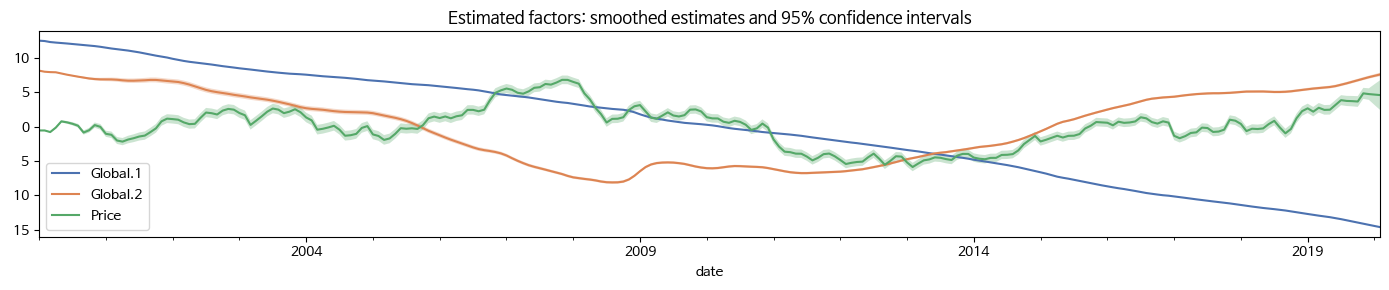

In [ ]:
# Get estimates of the global and labor market factors,
# conditional on the full dataset ("smoothed")
factor_names = ['Global.1', 'Global.2', 'Price']
mean = results.factors.smoothed[factor_names]

# Compute 95% confidence intervals
from scipy.stats import norm
std = pd.concat([results.factors.smoothed_cov.loc[name, name]
                 for name in factor_names], axis=1)
crit = norm.ppf(1 - 0.05 / 2)
lower = mean - crit * std
upper = mean + crit * std

with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 3))
    mean.plot(ax=ax)

    for name in factor_names:
        ax.fill_between(mean.index, lower[name], upper[name], alpha=0.3)

    ax.set(title='Estimated factors: smoothed estimates and 95% confidence intervals')
    fig.tight_layout();

In [ ]:
rsquared = results.get_coefficients_of_determination(method='individual')

top_ten = []
for factor_name in rsquared.columns[:2]:
    top_factor = (rsquared[factor_name].sort_values(ascending=False)
                                       .iloc[:10].round(2).reset_index())
    top_factor.columns = pd.MultiIndex.from_product([
        [f'Top ten variables explained by {factor_name}'],
        ['Variable', r'$R^2$']])
    top_ten.append(top_factor)
pd.concat(top_ten, axis=1)

Top ten variables explained by Global.1        \
                                 Variable $R^2$   
0                                     M70  0.99   
1                                     N85  0.99   
2                                     M68  0.99   
3                                     N83  0.99   
4                                     M69  0.99   
5                                     K49  0.99   
6                                    O100  0.99   
7                                     N87  0.99   
8                                     F27  0.98   
9                                     I37  0.98   

  Top ten variables explained by Global.2        
                                 Variable $R^2$  
0                                     N88  0.95  
1                                     N89  0.93  
2                                     N74  0.90  
3                                    O100  0.84  
4                                    O101  0.69  
5                                     H36  0.64  
6                                     N77  0.63  
7                                     H35  0.52  
8                                     L65  0.48  
9                                     O97  0.45

Text(0.5, 0.98, '$R^2$ - regression on individual factors')

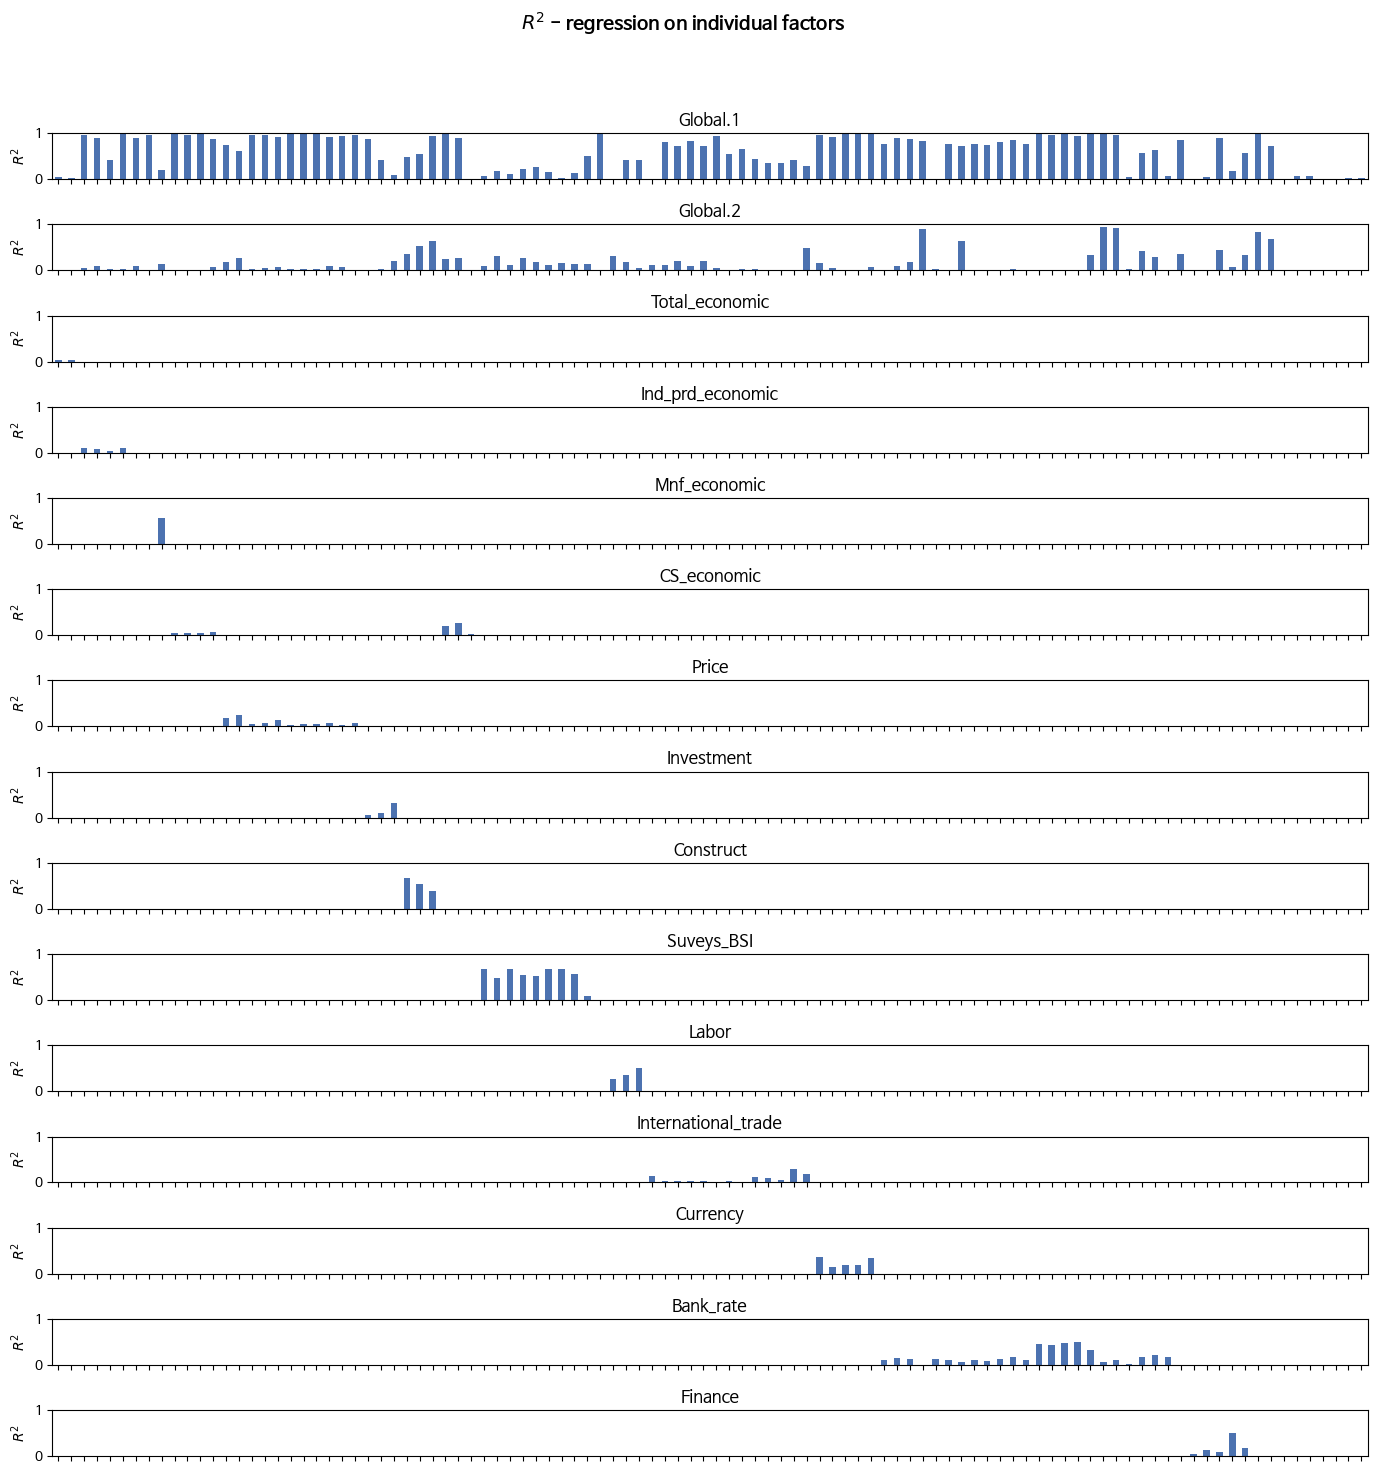

In [ ]:
with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='individual', figsize=(14, 15))
    fig.suptitle(r'$R^2$ - regression on individual factors', fontsize=14, fontweight=600)
    fig.tight_layout(rect=[0, 0, 1, 0.95]);

(0.0, 1.2)

Text(0.5, 1.1, '주요...')

Text(1.5, 1.1, '경기좁합\n...')

Text(2.5, 1.1, '산업생산\n...')

Text(3.5, 1.1, '제조업\n...')

Text(4.5, 1.1, '소비\n...')

Text(5.5, 1.1, '가격...')

Text(6.5, 1.1, '투자...')

Text(7.5, 1.1, '건설...')

Text(8.5, 1.1, '경기...')

Text(9.5, 1.1, '경제활동...')

Text(10.5, 1.1, '대외...')

Text(11.5, 1.1, '화폐\n유...')

Text(12.5, 1.1, '은행 \n여-수신\n...')

Text(13.5, 1.1, '금융...')

(-1.5, 102.5)

Text(100.9, 1.05, 'GDP')

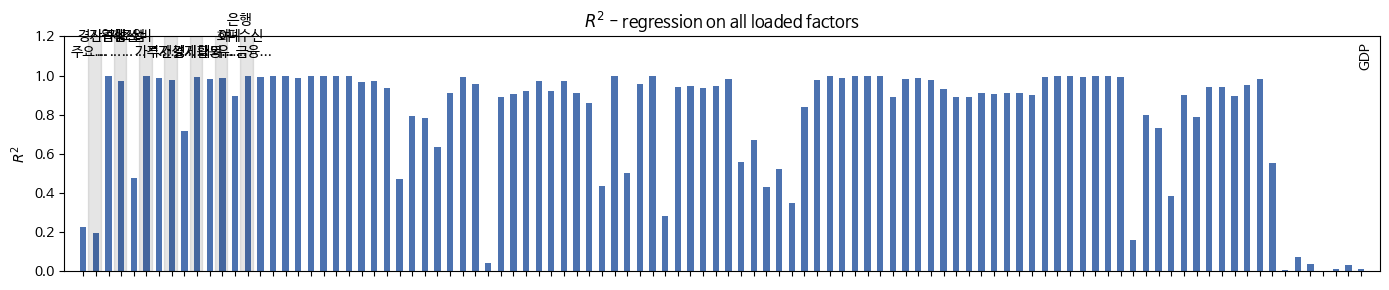

In [ ]:
group_counts = var_info[['description', 'Group']]
# group_counts = group_counts[group_counts['description'].isin(dta['2020-02'].dta_m.columns)]
group_counts = group_counts.groupby('Group', sort=False).count()['description'].cumsum()

with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='joint', figsize=(14, 3));

    # Add in group labels
    ax = fig.axes[0]
    ax.set_ylim(0, 1.2)
    for i in np.arange(1, len(group_counts), 2):
        start = 0 if i == 0 else group_counts[i - 1]
        end = group_counts[i] + 1
        ax.fill_between(np.arange(start, end) - 0.6, 0, 1.2, color='k', alpha=0.1)
    for i in range(len(group_counts)):
        start = 0 if i == 0 else group_counts[i - 1]
        end = group_counts[i]
        n = end - start
        text = group_counts.index[i]
        if len(text) > n:
            text = text[:n - 3] + '...'

        ax.annotate(text, (start + n / 2, 1.1), ha='center')

    # Add label for GDP
    ax.set_xlim(-1.5, model.k_endog + 0.5)
    ax.annotate('GDP', (model.k_endog - 1.1, 1.05), ha='left', rotation=90)

    fig.tight_layout();

In [ ]:
# Create point forecasts, 3 steps ahead
point_forecasts = results.forecast(steps=3)

# Print the forecasts for the first 5 observed variables
print(point_forecasts.T.head(100))

           2020-03       2020-04       2020-05
B7    9.888919e+01  9.890718e+01  9.892341e+01
B8    9.967371e+01  9.966746e+01  9.966109e+01
C9    1.029164e+02  1.031613e+02  1.033987e+02
C10   1.027203e+02  1.030025e+02  1.032746e+02
C11   9.900143e+01  9.956125e+01  1.000972e+02
...            ...           ...           ...
O102  1.939524e+06  1.918793e+06  1.923609e+06
A1    8.480491e-01  6.281177e-01  5.440972e-01
A2   -1.254038e+00 -8.009412e-01 -3.185513e-01
A3    4.809740e-01  2.706450e-01  1.388610e+00
A4    1.175999e+00  1.528153e+00  3.186470e-01

[100 rows x 3 columns]


<Axes: >

<Axes: >

Text(2020-01, -1.7, ' Forecast $\\rightarrow$')

[Text(0.5, 1.0, 'Treasury securities / Federal Funds Rate spreads: in-sample predictions and out-of-sample forecasts, with 95% confidence intervals'),
 (54.70630595941426, 122.81283377721827)]

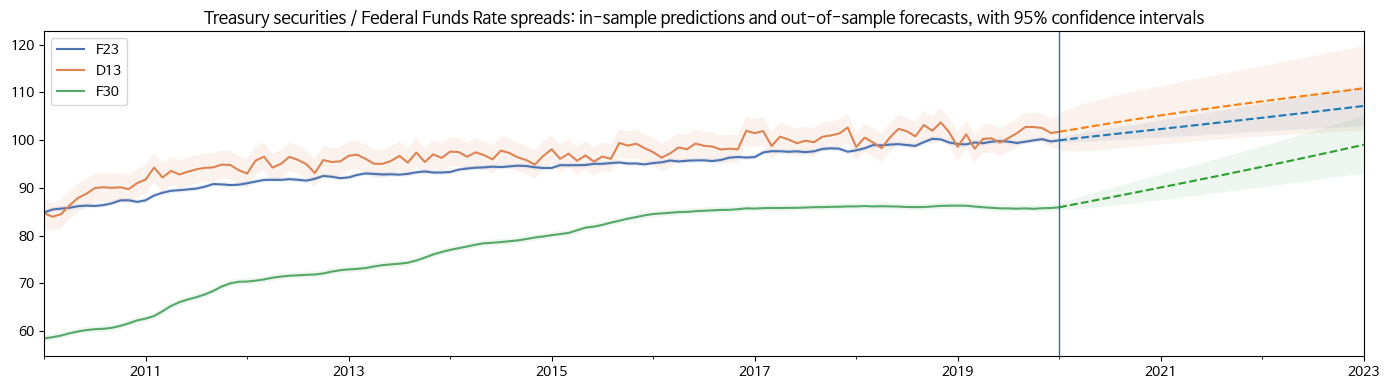

In [ ]:
# Create forecasts results objects, through the end of 20201
prediction_results = results.get_prediction(start='2010', end='2023')

variables = ['F23','D13','F30']
# ['1-Year Treasury C Minus FEDFUNDS',
#             '5-Year Treasury C Minus FEDFUNDS',
#             '10-Year Treasury C Minus FEDFUNDS']

# The `predicted_mean` attribute gives the same
# point forecasts that would have been returned from
# using the `predict` or `forecast` methods.
point_predictions = prediction_results.predicted_mean[variables]

# We can use the `conf_int` method to get confidence
# intervals; here, the 95% confidence interval
ci = prediction_results.conf_int(alpha=0.05)
lower = ci[[f'lower {name}' for name in variables]]
upper = ci[[f'upper {name}' for name in variables]]

# Plot the forecasts and confidence intervals
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 4))

    # Plot the in-sample predictions
    point_predictions.loc[:'2020-01'].plot(ax=ax)

    # Plot the out-of-sample forecasts
    point_predictions.loc['2020-01':].plot(ax=ax, linestyle='--',
                                           color=['C0', 'C1', 'C2'],
                                           legend=False)

    # Confidence intervals
    for name in variables:
        ax.fill_between(ci.index,
                        lower[f'lower {name}'],
                        upper[f'upper {name}'], alpha=0.1)

    # Forecast period, set title
    ylim = ax.get_ylim()
    ax.vlines('2020-01', ylim[0], ylim[1], linewidth=1)
    ax.annotate(r' Forecast $\rightarrow$', ('2020-01', -1.7))
    ax.set(title=('Treasury securities / Federal Funds Rate spreads:'
                  ' in-sample predictions and out-of-sample forecasts, with 95% confidence intervals'), ylim=ylim)

    fig.tight_layout()

In [ ]:
# Get the titles of the variables as they appear in the dataset
unemp_description = 'Civilian Unemployment Rate'
gdp_description = 'Real Gross Domestic Product, 3 Decimal (Billions of Chained 2012 Dollars)'

# Compute the point forecasts
fcast_m = results.forecast('2021-12')[unemp_description]
fcast_q = results.forecast('2021-12')[gdp_description].resample('Q').last()

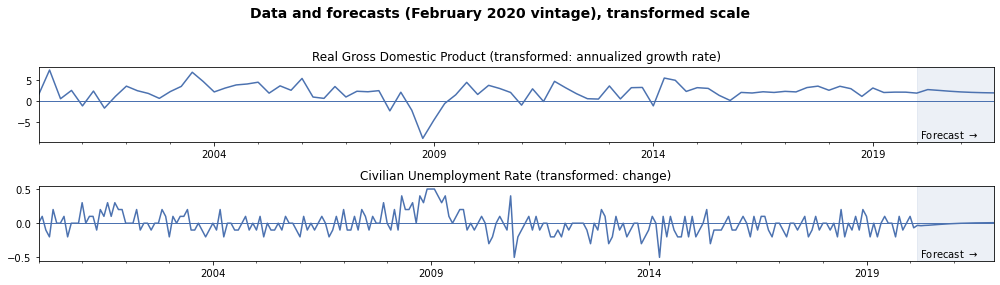

In [ ]:
# For more convenient plotting, combine the observed data with the forecasts
plot_m = pd.concat([dta['2020-02'].dta_m.loc['2000':, unemp_description], fcast_m])
plot_q = pd.concat([dta['2020-02'].dta_q.loc['2000':, gdp_description], fcast_q])

with sns.color_palette('deep'):
    fig, axes = plt.subplots(2, figsize=(14, 4))

    # Plot real GDP growth, data and forecasts
    plot_q.plot(ax=axes[0])
    axes[0].set(title='Real Gross Domestic Product (transformed: annualized growth rate)')
    axes[0].hlines(0, plot_q.index[0], plot_q.index[-1], linewidth=1)

    # Plot the change in the unemployment rate, data and forecasts
    plot_m.plot(ax=axes[1])
    axes[1].set(title='Civilian Unemployment Rate (transformed: change)')
    axes[1].hlines(0, plot_m.index[0], plot_m.index[-1], linewidth=1)

    # Show the forecast period in each graph
    for i in range(2):
        ylim = axes[i].get_ylim()
        axes[i].fill_between(plot_q.loc['2020-02':].index,
                             ylim[0], ylim[1], alpha=0.1, color='C0')
        axes[i].annotate(r' Forecast $\rightarrow$',
                         ('2020-03', ylim[0] + 0.1 * ylim[1]))
        axes[i].set_ylim(ylim)

    # Title
    fig.suptitle('Data and forecasts (February 2020 vintage), transformed scale',
                 fontsize=14, fontweight=600)

    fig.tight_layout(rect=[0, 0, 1, 0.95]);

In [ ]:
# Reverse the transformations

# For real GDP, we take the level in 2000Q1 from the original data,
# and then apply the growth rates to compute the remaining levels
plot_q_orig = (plot_q / 100 + 1)**0.25
plot_q_orig.loc['2000Q1'] = dta['2020-02'].orig_q.loc['2000Q1', gdp_description]
plot_q_orig = plot_q_orig.cumprod()

# For the unemployment rate, we take the level in 2000-01 from
# the original data, and then we apply the changes to compute the
# remaining levels
plot_m_orig = plot_m.copy()
plot_m_orig.loc['2000-01'] = dta['2020-02'].orig_m.loc['2000-01', unemp_description]
plot_m_orig = plot_m_orig.cumsum()

In [ ]:
with sns.color_palette('deep'):
    fig, axes = plt.subplots(2, figsize=(14, 4))

    # Plot real GDP, data and forecasts
    plot_q_orig.plot(ax=axes[0])
    axes[0].set(title=('Real Gross Domestic Product'
                       ' (original scale: Billions of Chained 2012 Dollars)'))

    # Plot the unemployment rate, data and forecasts
    plot_m_orig.plot(ax=axes[1])
    axes[1].set(title='Civilian Unemployment Rate (original scale: Percent)')

    # Show the forecast period in each graph
    for i in range(2):
        ylim = axes[i].get_ylim()
        axes[i].fill_between(plot_q.loc['2020-02':].index,
                             ylim[0], ylim[1], alpha=0.1, color='C0')
        axes[i].annotate(r' Forecast $\rightarrow$',
                         ('2020-03', ylim[0] + 0.5 * (ylim[1] - ylim[0])))
        axes[i].set_ylim(ylim)

    # Title
    fig.suptitle('Data and forecasts (February 2020 vintage), original scale',
                 fontsize=14, fontweight=600)

    fig.tight_layout(rect=[0, 0, 1, 0.95]);

In [ ]:
# The original point forecasts are monthly
point_forecasts_m = results.forecast('June 2020')[gdp_description]

# Resample to quarterly frequency by taking the value in the last
# month of each quarter
point_forecasts_q = point_forecasts_m.resample('Q').last()

print('Baseline (February 2020) forecast for real GDP growth'
      f' in 2020Q2: {point_forecasts_q["2020Q2"]:.2f}%')